## Melanoma Detection

**Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [18]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Activation, MaxPool2D, Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomWidth, RandomHeight
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

In [2]:
data_dir_train = pathlib.Path(r'Train')
data_dir_test = pathlib.Path(r'Test')

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing
Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [4]:
batch_size = 32
img_height = 180
img_width = 180

Using 80% of the images for training, and 20% for validation.

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

train_ds

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

In [7]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [8]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

In [9]:
import matplotlib.pyplot as plt

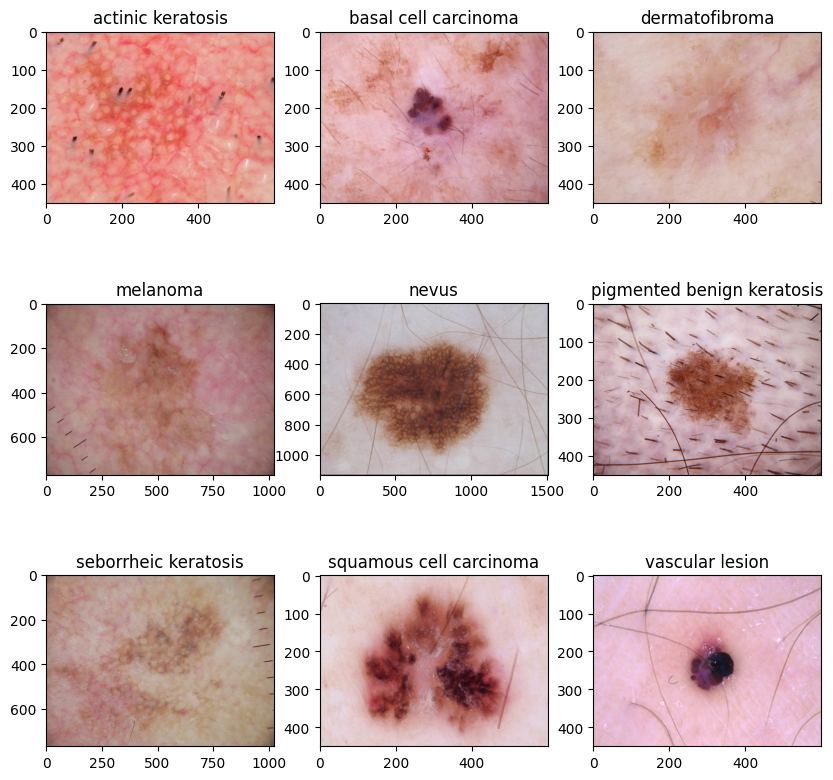

In [10]:
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

In [12]:
model = Sequential([
    Rescaling(1./255, input_shape=(180, 180, 3)),  
    Conv2D(32, (5, 5), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),  
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax') 
])


model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,929,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,025,929 (30.62 MB)

 Trainable params: 8,025,929 (30.62 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the model

In [13]:
optimizer = 'adam'
loss_fn = "categorical_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])


### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 482ms/step - accuracy: 0.1681 - loss: 2.5103 - val_accuracy: 0.3110 - val_loss: 1.9579
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 530ms/step - accuracy: 0.2483 - loss: 1.9924 - val_accuracy: 0.2998 - val_loss: 2.0388
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 539ms/step - accuracy: 0.2991 - loss: 1.9159 - val_accuracy: 0.3982 - val_loss: 1.7351
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 546ms/step - accuracy: 0.3733 - loss: 1.7572 - val_accuracy: 0.4049 - val_loss: 1.6927
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 561ms/step - accuracy: 0.4128 - loss: 1.6751 - val_accuracy: 0.4228 - val_loss: 1.5855
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 562ms/step - accuracy: 0.4577 - loss: 1.5661 - val_accuracy: 0.5168 - val_loss: 1.4757
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 565ms/step - accuracy: 0.4698 - loss: 1.5011 - val_accuracy: 0.5302 - val_loss: 1.4133
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 580ms/step - accuracy: 0.4742 - loss: 1.5182 - val_accu

### Visualizing training results

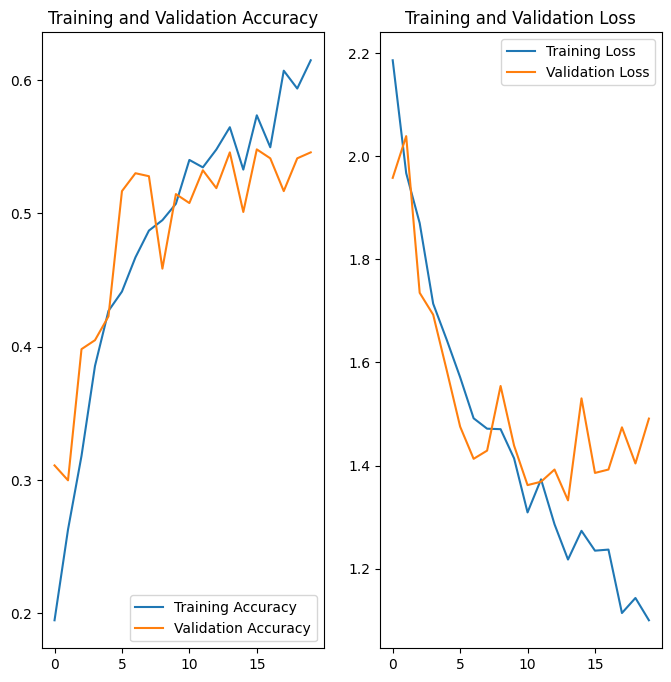

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.6776 - loss: 0.8894
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.6055 - loss: 1.4513
Accuracy:  0.6852678656578064
Validation Accuracy:  0.5458613038063049
Loss:  0.8646162152290344
Validation Loss 1.4912465810775757


Looking at the above results. The model seems to be overfitting. 
To overcome this we can choose the right Data Augmentation strategy

In [58]:
data_augmentation = keras.Sequential([
                             layers.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.RandomRotation(0.2, fill_mode='reflect'),
                             layers.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

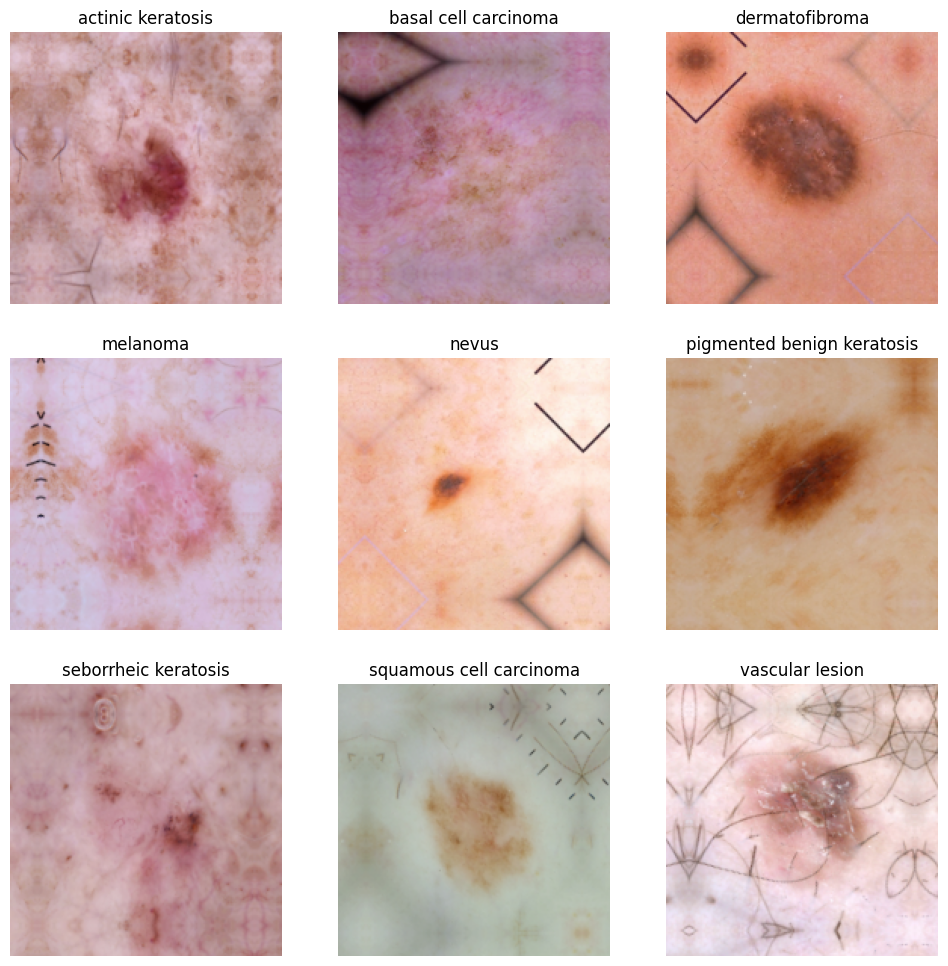

In [59]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augmentation(images)[i].numpy().astype("uint8"))
        plt.title(class_names[i])
        plt.axis("off")

In [68]:
model = Sequential([
    data_augmentation,
    Rescaling(1./255, input_shape=(180, 180, 3)), 
    Conv2D(32, (5, 5), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),  
    Dense(124, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax')  
])


In [69]:
optimizer = 'adam'
loss_fn = "categorical_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])


In [70]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 28s 478ms/step - accuracy: 0.1853 - loss: 2.1700 - val_accuracy: 0.3400 - val_loss: 1.8564
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 531ms/step - accuracy: 0.3003 - loss: 1.8826 - val_accuracy: 0.3893 - val_loss: 1.6672
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 536ms/step - accuracy: 0.3421 - loss: 1.7726 - val_accuracy: 0.3758 - val_loss: 1.6633
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 553ms/step - accuracy: 0.3514 - loss: 1.7623 - val_accuracy: 0.3624 - val_loss: 1.7269
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 541ms/step - accuracy: 0.3059 - loss: 1.8729 - val_accuracy: 0.3758 - val_loss: 1.7231
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 575ms/step - accuracy: 0.3485 - loss: 1.7768 - val_accuracy: 0.4139 - val_loss: 1.6365
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 595ms/step - accuracy: 0.3672 - loss: 1.7102 - val_accuracy: 0.4049 - val_loss: 1.6642
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 584ms/step - accuracy: 0.3877 - loss: 1.7219 - val_accu

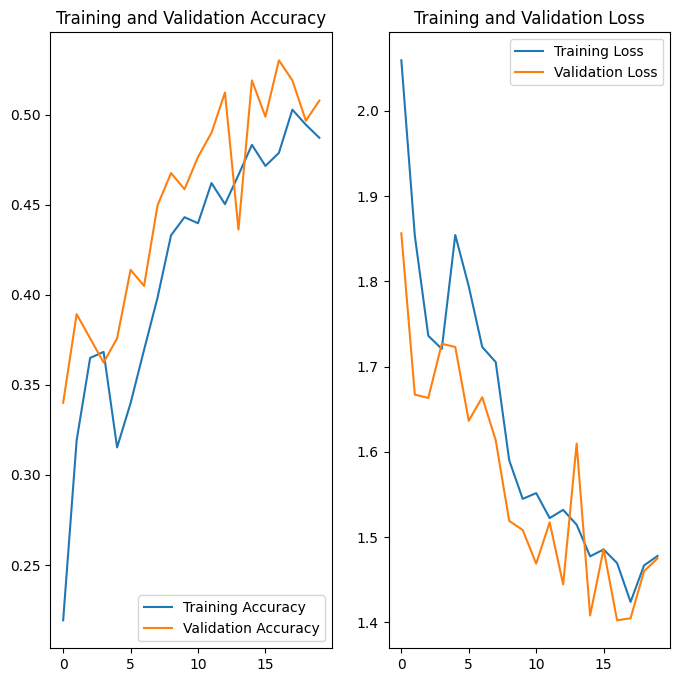

In [73]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [72]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step - accuracy: 0.5101 - loss: 1.4092
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.5475 - loss: 1.3789
Accuracy:  0.5150669813156128
Validation Accuracy:  0.5078299641609192
Loss:  1.3870235681533813
Validation Loss 1.4751205444335938


#### **Todo:** Find the distribution of classes in the training dataset.
 **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

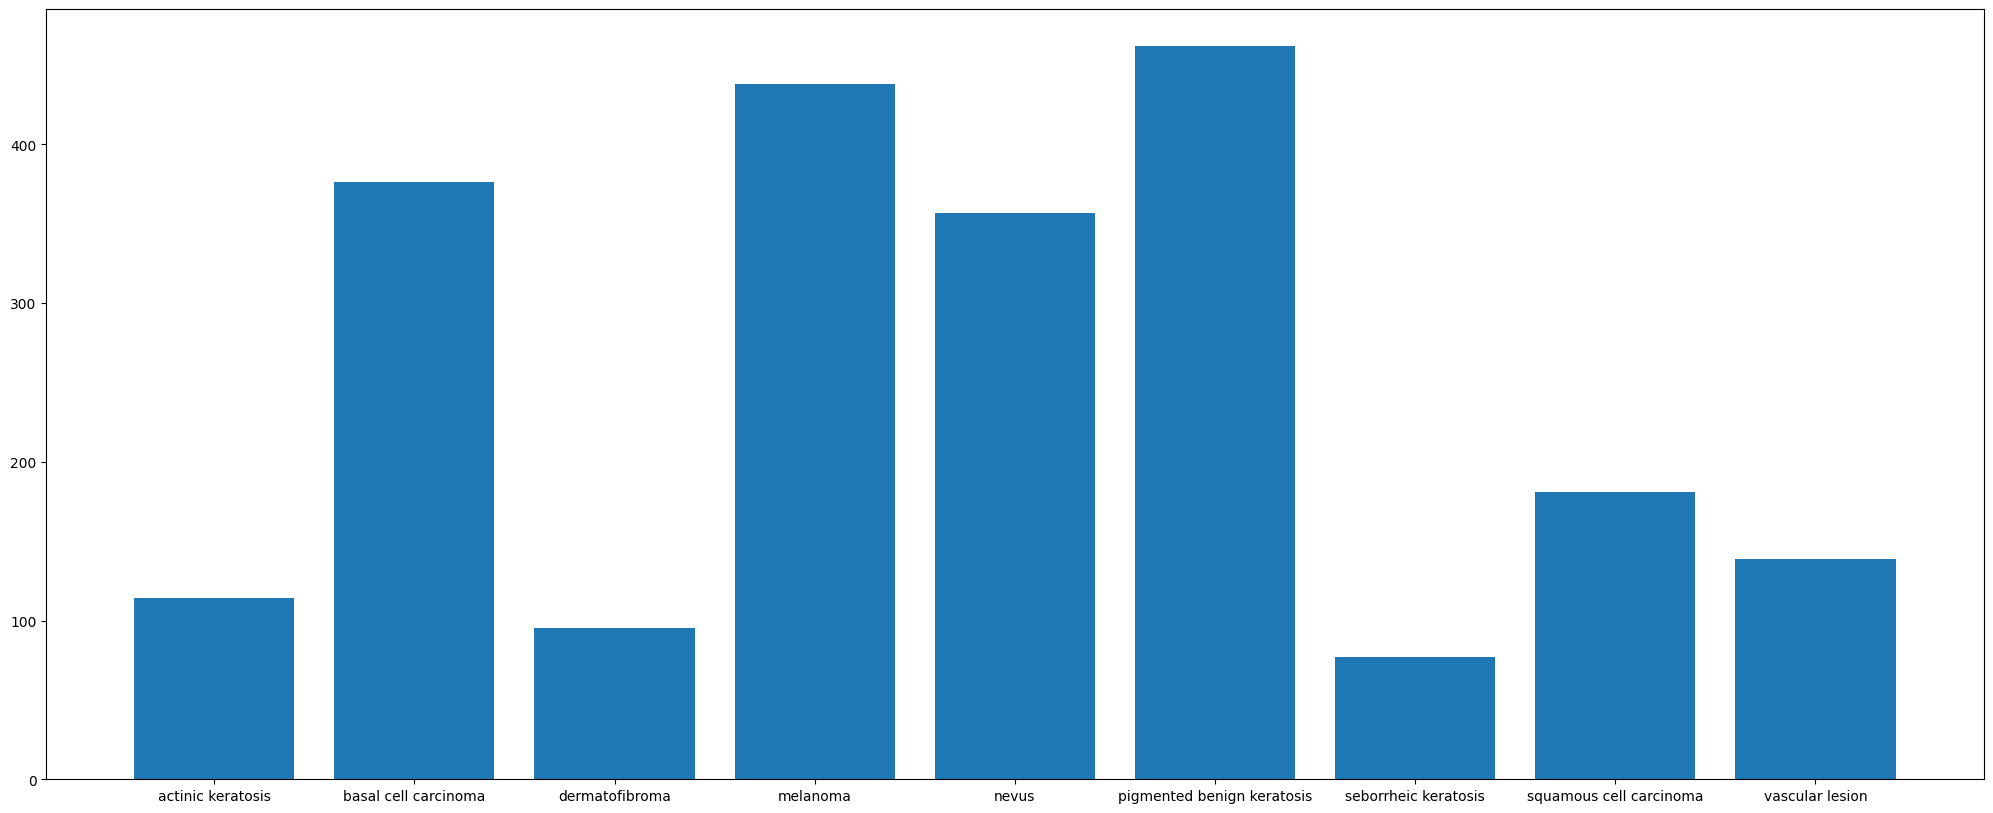

In [74]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

- Which class has the least number of samples? --> seborrheic keratosis
- Which classes dominate the data in terms proportionate number of samples? -->  pigmented benign keratosis

In [75]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

### Rectify the class imbalance
You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [77]:
!pip3 install Augmentor


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.12 -m pip install --upgrade pip


To use Augmentor, the following general procedure is followed:

Instantiate a Pipeline object pointing to a directory containing your initial image data set.
Define a number of operations to perform on this data set using your Pipeline object.
Execute these operations by calling the Pipeline’s sample() method.

In [78]:
path_to_training_dataset ="Train/"

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1506AC6B0>: 100%|█████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 280.80 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16BF794C0>: 100%|█████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 296.00 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16B872540>: 100%|█████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 264.53 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x151CD67B0>: 100%|████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 66.72 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1504x1129 at 0x154A10470>: 100%|██████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 67.54 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x153F6A300>: 100%|█████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 256.72 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x15553BE00>: 100%|████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 124.70 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x15552AB10>: 100%|███████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 296.36 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x154C082C0>: 100%|█████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 280.67 Samples/s]


In [79]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [80]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Train/melanoma/output/melanoma_original_ISIC_0009868.jpg_5488d54e-d999-4366-ab1e-d1c7c34aa11f.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0000312.jpg_774d7fa9-43bc-4c6f-b8ea-350e6919fbe3.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010898.jpg_d75110e1-8d31-4e5c-ab03-d3f01e221df6.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010036.jpg_975c0f1c-d9e6-4781-9572-9b9024783495.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010596.jpg_8c2583dc-4f07-48ee-a907-e96d0d6bbe40.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010767.jpg_b5e88395-5146-4f30-9593-463d4668dfdc.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010397.jpg_ce7e4c60-e748-41d9-9107-417bff24878c.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010207.jpg_7fe6d904-369f-45c7-85dc-88d4ae5a7573.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0000466.jpg_506f22ba-eb48-43fc-abff-f8b818042233.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0001116.jpg_845459f3-84ab-44a3-a14b

In [81]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [83]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [85]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [87]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [88]:
new_df['Label'].value_counts()


Label
melanoma                      500
pigmented benign keratosis    500
nevus                         500
basal cell carcinoma          500
actinic keratosis             500
squamous cell carcinoma       500
vascular lesion               500
seborrheic keratosis          500
dermatofibroma                500
Name: count, dtype: int64

### Train the model on the data created using Augmentor

In [89]:
batch_size = 32
img_height = 180
img_width = 180

In [92]:
data_dir_train=pathlib.Path(r'Train')
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  label_mode='categorical',
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [93]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  label_mode='categorical',
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Model Creation

In [94]:
model = Sequential()

model.add(Rescaling(1./255,input_shape=(180,180,3)))  

model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))


model.add(layers.Dropout(0.5))

model.add(layers.Flatten())


model.add(layers.Dense(128,activation='relu'))


model.add(layers.Dropout(0.25))

model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_12 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

#### Compile the model

In [104]:
optimizer = Adam(learning_rate=1e-4)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

#### Train the model with epochs as 50 

In [106]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 1053s 6s/step - accuracy: 0.6414 - loss: 0.9825 - val_accuracy: 0.6570 - val_loss: 0.9777
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 1117s 7s/step - accuracy: 0.6554 - loss: 0.9298 - val_accuracy: 0.6741 - val_loss: 0.9414
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 1193s 7s/step - accuracy: 0.6767 - loss: 0.8741 - val_accuracy: 0.6741 - val_loss: 0.9165
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 2066s 12s/step - accuracy: 0.6868 - loss: 0.8334 - val_accuracy: 0.6927 - val_loss: 0.8817
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 3722s 22s/step - accuracy: 0.7117 - loss: 0.8134 - val_accuracy: 0.7030 - val_loss: 0.8325
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 1141s 7s/step - accuracy: 0.7304 - loss: 0.7502 - val_accuracy: 0.6993 - val_loss: 0.8310
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 4338s 26s/step - accuracy: 0.7404 - loss: 0.6973 - val_accuracy: 0.7268 - val_loss: 0.7826
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 2085s 12s/step - accuracy: 0.7539 - loss: 0.674

### Visualize the model results

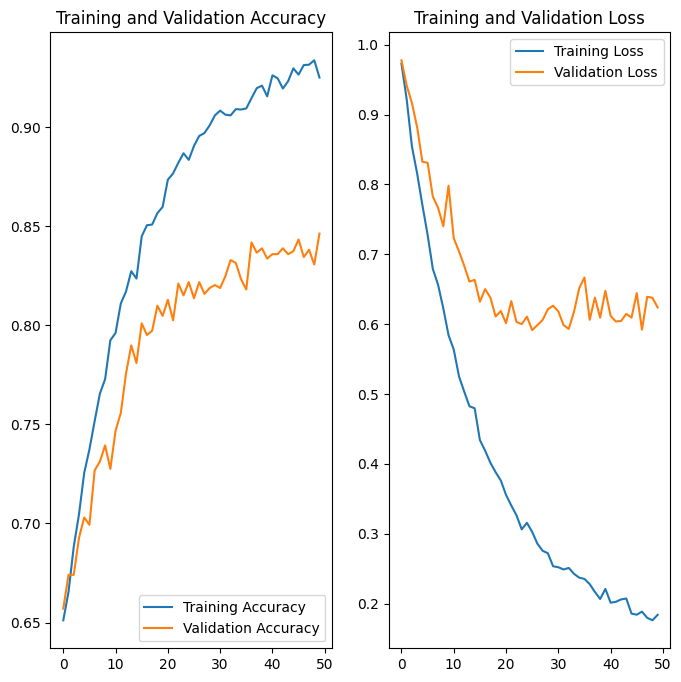

In [107]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [109]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

169/169 ━━━━━━━━━━━━━━━━━━━━ 25s 148ms/step - accuracy: 0.9556 - loss: 0.1005
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.8465 - loss: 0.6270
Accuracy:  0.9604970216751099
Validation Accuracy:  0.846325159072876
Loss:  0.09591452777385712
Validation Loss 0.623955488204956


### Analyzing the results
* We got rid of overfitting by using augmentation, normalisation and dropout.
* Class rebalance has helped improve the accuracy